# Dueling DQN-TensorFlow

Here we use the `Keras` API of `TensorFlow2.0` to play `CartPole` game.

### 1. Import Labraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline

/Users/william/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 2. Define a class to store memory for training

This memory can store an experience $(state, action, reward, next state, terminal)$.

Also it can sample some experiences for training.

In [2]:
class Memory:
    def __init__(self, size):
        self.memory_size = size
        self.memory = {
            's': None,
            'a': None,
            'r': None,
            's_': None,
            't': None
        }
    
    def store(self, s, a, r, s_, t):
        s = np.expand_dims(s, axis=0)  # add batch dimension
        a = np.array(a)
        r = np.array(r)
        s_ = np.expand_dims(s_, axis=0)  # add batch dimension
        t = np.array(t)
        
        if self.current_size >= self.memory_size:
            self.memory = self._delete(self.memory)
        
        if self.memory['s'] is None:
            self.memory['s'] = s
            self.memory['a'] = a
            self.memory['r'] = r
            self.memory['s_'] = s_
            self.memory['t'] = t
        else:
            self.memory['s'] = np.concatenate((self.memory['s'], s), axis=0)
            self.memory['a'] = np.hstack([self.memory['a'], a])
            self.memory['r'] = np.hstack([self.memory['r'], r])
            self.memory['s_'] = np.concatenate([self.memory['s_'], s_], axis=0)
            self.memory['t'] = np.hstack([self.memory['t'], t])
            
    def _delete(self, memory):
        # delete the first experience
        memory = {k: v[1:, ...] for k, v in memory.items()}
        assert len(memory['s']) <= self.memory_size
        
        return memory
    
    def sample(self, n):
        indices = np.random.choice(self.current_size, n)
        samples = {k: v[indices] for k, v in self.memory.items()}
        
        return samples
    
    @property
    def current_size(self):
        if self.memory['s'] is None:
            return 0
        else:
            return len(self.memory['s'])

### 3. Define a class for dueling deep Q network

In [3]:
class DuelingDQN:
    def __init__(self,
                 n_actions,
                 n_features,
                 learning_rate=0.001,
                 discount=0.9,
                 epsilon_greedy=0.9,
                 epsilon_greedy_increment=None,
                 update_target_iter=50,
                 memory_size=500,
                 batch_size=32,
                 dueling=True
                ):
        self.n_actions = n_actions  # 2 for CartPole
        self.n_features = n_features  # 4 for CartPole
        self.learning_rate = learning_rate
        self.discount = discount
        self.batch_size = batch_size
        self.epsilon_max = epsilon_greedy
        self.epsilon_increment = epsilon_greedy_increment
        self.epsilon = 0 if epsilon_greedy_increment is not None else self.epsilon_max
        
        self.dueling = dueling
        
        # record the times of training
        self.learn_steps = 0
        
        # fix the target Q network until `learn_steps` is a multiple of `update_target_iter`
        # otherwise, update the target Q network
        self.update_target_iter = update_target_iter
        
        # build a deep Q network and a traget Q network
        self._build()
        
        # build a memory
        self.memory = Memory(size=memory_size)
        
        self.loss_list = []
        
    def _build(self):
        if self.dueling:
            input = tf.keras.layers.Input((self.n_features,))
            hidden = tf.keras.layers.Dense(32, activation='relu')(input)
            hidden = tf.keras.layers.Dense(31, activation='relu')(hidden)

            V = tf.keras.layers.Dense(1, activation='linear')(hidden)
            A = tf.keras.layers.Dense(self.n_actions, activation='linear')(hidden)

            A_mean = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(A)

            output = tf.keras.layers.Add()([V, A])
            output = tf.keras.layers.Subtract()([output, A_mean])

            self.q = tf.keras.models.Model(inputs=input, outputs=output)
        else:
            self.q = tf.keras.models.Sequential()
            self.q.add(tf.keras.layers.Dense(32, activation='relu',
                                             input_shape=(self.n_features,)))
            self.q.add(tf.keras.layers.Dense(32, activation='relu'))
            self.q.add(tf.keras.layers.Dense(self.n_actions, activation='linear'))
        
        self.q_target = tf.keras.models.clone_model(self.q)
        self._update_target()
        
        self.q.compile(optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                       loss=tf.keras.losses.mse
                      )
    
    def store(self, s, a, r, s_, t):
        # store memory
        self.memory.store(s, a, r, s_, t)
        
    def choose_action(self, s):
        s = np.expand_dims(s, axis=0)
        
        if np.random.uniform() < self.epsilon:
            q_value = self.q.predict(s)
            action = np.argmax(q_value)
        else:
            action = np.random.choice(self.n_actions)
            
        return action
        
    def learn(self):
        # update `q_target` every `update_target_iter`
        # otherwise, fix `q_target`
        if self.learn_steps % self.update_target_iter == 0:
            self._update_target()
        
        # sample a batch of training data
        memory_samples = self.memory.sample(self.batch_size)
        
        s = memory_samples['s']
        a = memory_samples['a']
        r = memory_samples['r']
        s_ = memory_samples['s_']
        t = memory_samples['t']
        
        
        q_target = self.q.predict(s)  # target q value
        q_next = self.q_target.predict(s_)  # q value of next state by `q_target`
        
        # replace the target q value corresponding the action selected by real target q value
        # the other values remain so that it is no matter when computing mse loss
        for i in range(len(q_target)):
            if t[i]:
                q_target[i, a[i]] = r[i]
            else:
                q_target[i, a[i]] = r[i] + self.discount * np.max(q_next[i])
        
        # update `q`
        loss = self.q.train_on_batch(s, q_target)
        self.loss_list.append(loss)
        
        # gradually increase the value of `epsilon`
        if self.epsilon_increment is not None:
            self.epsilon = self.epsilon + self.epsilon_increment
            self.epsilon = self.epsilon if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_steps += 1
        
    def _update_target(self):
        # get the weights of `q`
        q_weights = self.q.get_weights()
        
        # assign the weights of q to `q_target`
        self.q_target.set_weights(q_weights)
        print('update_target')
        
    def plot_loss(self):
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(self.loss_list)), self.loss_list)
        plt.ylabel('Loss')
        plt.xlabel('training steps')
        plt.show()

### 4. Let's train a dueling DQN!

##### 4.1 Create an environment

In [4]:
import gym
env = gym.make('CartPole-v1')
state = env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/william/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


##### 4.2 Create an actor

In [5]:
actor  = DuelingDQN(n_actions=env.action_space.n,
                    n_features=len(state),
                    batch_size=32,
                    discount=0.9,
                    memory_size=1000,
                    epsilon_greedy=1.0,
                    epsilon_greedy_increment=0.001,
                    dueling=True
                   )

update_target


##### 4.3 Train the actor

In [6]:
actor1 = DuelingDQN(n_actions=env.action_space.n,
                    n_features=len(state),
                    batch_size=32,
                    discount=0.9,
                    memory_size=1000,
                    epsilon_greedy=1.0,
                    epsilon_greedy_increment=0.001,
                    dueling=True
                   )

update_target


In [7]:
step = 0
rewards1 = []

for episode in range(500):
    period = 0
    total_reward = 0
    
    state = env.reset()
    
    while True:
        env.render()
        
        # actor chooses an action
        action = actor1.choose_action(state)
        
        # use the action to update the environment
        state_next, reward, done, info = env.step(action)
        
        # if game is over, set reward = -1
        # if game is not over, reward = +1
        if done:
            reward = - reward
        
        total_reward += reward
        
        # store this experience
        actor1.store(state, action, reward, state_next, done)
        
        # train your actor if it has 100 or more experiences
        # train your actor every 5 steps
        # you can tune these value by yourself
        if step > 100 and step % 5 == 0:
            actor1.learn()
        
        # jump to next state
        state = state_next
        
        if done:
            break
        step += 1
        period += 1
    
    print('Episode: {:3d}, reward: {:3d}, epsilon: {:.4f}'.format(episode, int(total_reward), actor1.epsilon))
    rewards1.append(total_reward)

print('game over')

Episode:   0, reward:  17, epsilon: 0.0000
Episode:   1, reward:  15, epsilon: 0.0000
Episode:   2, reward:   7, epsilon: 0.0000
Episode:   3, reward:  30, epsilon: 0.0000
Episode:   4, reward:  18, epsilon: 0.0000
update_target
Episode:   5, reward:  18, epsilon: 0.0020
Episode:   6, reward:   9, epsilon: 0.0040
Episode:   7, reward:  33, epsilon: 0.0110
Episode:   8, reward:  23, epsilon: 0.0160
Episode:   9, reward:  12, epsilon: 0.0190
Episode:  10, reward:  12, epsilon: 0.0220
Episode:  11, reward:  17, epsilon: 0.0260
Episode:  12, reward:  16, epsilon: 0.0300
Episode:  13, reward:   7, epsilon: 0.0320
Episode:  14, reward:  18, epsilon: 0.0360
Episode:  15, reward:  10, epsilon: 0.0380
Episode:  16, reward:  18, epsilon: 0.0420
Episode:  17, reward:  10, epsilon: 0.0440
Episode:  18, reward:   7, epsilon: 0.0460
Episode:  19, reward:  15, epsilon: 0.0490
update_target
Episode:  20, reward:  12, epsilon: 0.0520
Episode:  21, reward:   9, epsilon: 0.0550
Episode:  22, reward:  10,

Episode: 182, reward: 133, epsilon: 1.0000
update_target
Episode: 183, reward: 145, epsilon: 1.0000
update_target
Episode: 184, reward: 115, epsilon: 1.0000
Episode: 185, reward:  87, epsilon: 1.0000
Episode: 186, reward:  87, epsilon: 1.0000
update_target
Episode: 187, reward: 121, epsilon: 1.0000
Episode: 188, reward:  84, epsilon: 1.0000
update_target
Episode: 189, reward: 147, epsilon: 1.0000
Episode: 190, reward: 204, epsilon: 1.0000
update_target
Episode: 191, reward: 118, epsilon: 1.0000
Episode: 192, reward:  80, epsilon: 1.0000
update_target
Episode: 193, reward: 136, epsilon: 1.0000
Episode: 194, reward:  82, epsilon: 1.0000
update_target
Episode: 195, reward: 100, epsilon: 1.0000
Episode: 196, reward: 100, epsilon: 1.0000
update_target
Episode: 197, reward: 216, epsilon: 1.0000
update_target
Episode: 198, reward: 180, epsilon: 1.0000
Episode: 199, reward: 160, epsilon: 1.0000
update_target
Episode: 200, reward: 236, epsilon: 1.0000
update_target
Episode: 201, reward:  83, ep

update_target
Episode: 328, reward: 232, epsilon: 1.0000
update_target
Episode: 329, reward: 219, epsilon: 1.0000
Episode: 330, reward: 184, epsilon: 1.0000
update_target
Episode: 331, reward: 188, epsilon: 1.0000
update_target
Episode: 332, reward: 209, epsilon: 1.0000
update_target
Episode: 333, reward: 207, epsilon: 1.0000
update_target
Episode: 334, reward: 228, epsilon: 1.0000
update_target
Episode: 335, reward: 239, epsilon: 1.0000
update_target
Episode: 336, reward: 311, epsilon: 1.0000
update_target
Episode: 337, reward: 233, epsilon: 1.0000
update_target
Episode: 338, reward: 207, epsilon: 1.0000
Episode: 339, reward: 184, epsilon: 1.0000
update_target
Episode: 340, reward: 193, epsilon: 1.0000
update_target
Episode: 341, reward: 244, epsilon: 1.0000
update_target
Episode: 342, reward: 192, epsilon: 1.0000
update_target
Episode: 343, reward: 173, epsilon: 1.0000
update_target
Episode: 344, reward: 213, epsilon: 1.0000
Episode: 345, reward: 219, epsilon: 1.0000
update_target
Ep

update_target
Episode: 475, reward: 148, epsilon: 1.0000
Episode: 476, reward: 186, epsilon: 1.0000
update_target
Episode: 477, reward: 188, epsilon: 1.0000
update_target
Episode: 478, reward: 155, epsilon: 1.0000
Episode: 479, reward: 160, epsilon: 1.0000
update_target
Episode: 480, reward: 147, epsilon: 1.0000
update_target
Episode: 481, reward: 145, epsilon: 1.0000
Episode: 482, reward: 148, epsilon: 1.0000
update_target
Episode: 483, reward: 175, epsilon: 1.0000
update_target
Episode: 484, reward: 185, epsilon: 1.0000
Episode: 485, reward: 144, epsilon: 1.0000
update_target
Episode: 486, reward: 150, epsilon: 1.0000
Episode: 487, reward: 158, epsilon: 1.0000
update_target
Episode: 488, reward: 180, epsilon: 1.0000
update_target
Episode: 489, reward: 157, epsilon: 1.0000
update_target
Episode: 490, reward: 171, epsilon: 1.0000
Episode: 491, reward: 174, epsilon: 1.0000
update_target
Episode: 492, reward: 156, epsilon: 1.0000
Episode: 493, reward: 149, epsilon: 1.0000
update_target
E

##### 4.4 Plot the loss and the reward

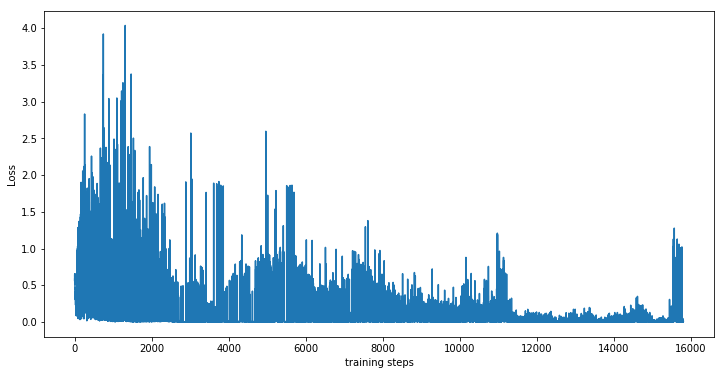

In [8]:
actor1.plot_loss()

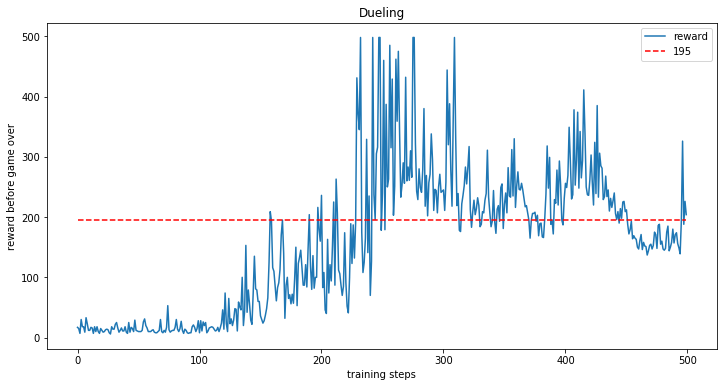

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(rewards1, label='reward')
plt.plot([195] * len(rewards1), c='r', linestyle='--', label='195')
plt.xlabel('training steps')
plt.ylabel('reward before game over')
plt.title('Dueling')
plt.legend();

### 5. Train a double DQN without dueling structure and compare to the dueling DQN

In [10]:
actor2 = DuelingDQN(n_actions=env.action_space.n,
                    n_features=len(state),
                    batch_size=32,
                    discount=0.9,
                    memory_size=1000,
                    epsilon_greedy=1.0,
                    epsilon_greedy_increment=0.001,
                    dueling=True
                   )

update_target


In [11]:
step = 0
rewards2 = []

for episode in range(500):
    period = 0
    total_reward = 0
    
    state = env.reset()
    
    while True:
        env.render()
        
        # actor chooses an action
        action = actor2.choose_action(state)
        
        # use the action to update the environment
        state_next, reward, done, info = env.step(action)
        
        # if game is over, set reward = -1
        # if game is not over, reward = +1
        if done:
            reward = - reward
        
        total_reward += reward
        
        # store this experience
        actor2.store(state, action, reward, state_next, done)
        
        # train your actor if it has 100 or more experiences
        # train your actor every 5 steps
        # you can tune these value by yourself
        if step > 100 and step % 5 == 0:
            actor2.learn()
        
        # jump to next state
        state = state_next
        
        if done:
            break
        step += 1
        period += 1
    
    print('Episode: {:3d}, reward: {:3d}, epsilon: {:.4f}'.format(episode, int(total_reward), actor2.epsilon))
    rewards2.append(total_reward)

print('game over')

Episode:   0, reward:  15, epsilon: 0.0000
Episode:   1, reward:  23, epsilon: 0.0000
Episode:   2, reward:  12, epsilon: 0.0000
Episode:   3, reward:  10, epsilon: 0.0000
Episode:   4, reward:  22, epsilon: 0.0000
update_target
Episode:   5, reward:  51, epsilon: 0.0070
Episode:   6, reward:  15, epsilon: 0.0110
Episode:   7, reward:  22, epsilon: 0.0160
Episode:   8, reward:  24, epsilon: 0.0210
Episode:   9, reward:  20, epsilon: 0.0250
Episode:  10, reward:  36, epsilon: 0.0330
Episode:  11, reward:  21, epsilon: 0.0370
Episode:  12, reward:  16, epsilon: 0.0410
Episode:  13, reward:  23, epsilon: 0.0460
Episode:  14, reward:   9, epsilon: 0.0480
update_target
Episode:  15, reward:  12, epsilon: 0.0510
Episode:  16, reward:  21, epsilon: 0.0550
Episode:  17, reward:  16, epsilon: 0.0590
Episode:  18, reward:  13, epsilon: 0.0620
Episode:  19, reward:  42, epsilon: 0.0710
Episode:  20, reward:  31, epsilon: 0.0780
Episode:  21, reward:  94, epsilon: 0.0980
Episode:  22, reward:   8,

Episode: 172, reward: 188, epsilon: 1.0000
update_target
Episode: 173, reward: 200, epsilon: 1.0000
Episode: 174, reward: 198, epsilon: 1.0000
update_target
Episode: 175, reward: 205, epsilon: 1.0000
update_target
Episode: 176, reward: 138, epsilon: 1.0000
update_target
Episode: 177, reward: 225, epsilon: 1.0000
update_target
Episode: 178, reward: 208, epsilon: 1.0000
Episode: 179, reward: 203, epsilon: 1.0000
update_target
Episode: 180, reward: 274, epsilon: 1.0000
update_target
update_target
Episode: 181, reward: 333, epsilon: 1.0000
update_target
Episode: 182, reward: 171, epsilon: 1.0000
update_target
Episode: 183, reward: 377, epsilon: 1.0000
update_target
Episode: 184, reward: 158, epsilon: 1.0000
Episode: 185, reward: 156, epsilon: 1.0000
update_target
Episode: 186, reward: 209, epsilon: 1.0000
update_target
Episode: 187, reward: 258, epsilon: 1.0000
update_target
Episode: 188, reward: 208, epsilon: 1.0000
update_target
update_target
Episode: 189, reward: 378, epsilon: 1.0000
up

update_target
Episode: 311, reward: 498, epsilon: 1.0000
update_target
Episode: 312, reward: 206, epsilon: 1.0000
update_target
Episode: 313, reward: 158, epsilon: 1.0000
Episode: 314, reward: 187, epsilon: 1.0000
update_target
Episode: 315, reward: 180, epsilon: 1.0000
update_target
Episode: 316, reward: 197, epsilon: 1.0000
update_target
Episode: 317, reward: 170, epsilon: 1.0000
Episode: 318, reward: 207, epsilon: 1.0000
update_target
Episode: 319, reward: 174, epsilon: 1.0000
update_target
Episode: 320, reward: 255, epsilon: 1.0000
update_target
Episode: 321, reward: 261, epsilon: 1.0000
update_target
Episode: 322, reward: 225, epsilon: 1.0000
update_target
Episode: 323, reward: 324, epsilon: 1.0000
update_target
update_target
Episode: 324, reward: 319, epsilon: 1.0000
update_target
update_target
Episode: 325, reward: 498, epsilon: 1.0000
update_target
Episode: 326, reward: 423, epsilon: 1.0000
update_target
Episode: 327, reward: 250, epsilon: 1.0000
update_target
update_target
Epi

Episode: 468, reward: 206, epsilon: 1.0000
Episode: 469, reward:  14, epsilon: 1.0000
update_target
Episode: 470, reward: 159, epsilon: 1.0000
Episode: 471, reward: 121, epsilon: 1.0000
update_target
Episode: 472, reward: 236, epsilon: 1.0000
update_target
Episode: 473, reward: 177, epsilon: 1.0000
update_target
Episode: 474, reward: 163, epsilon: 1.0000
Episode: 475, reward: 164, epsilon: 1.0000
update_target
Episode: 476, reward: 167, epsilon: 1.0000
update_target
Episode: 477, reward: 192, epsilon: 1.0000
update_target
Episode: 478, reward: 161, epsilon: 1.0000
Episode: 479, reward: 184, epsilon: 1.0000
update_target
Episode: 480, reward: 163, epsilon: 1.0000
update_target
Episode: 481, reward: 164, epsilon: 1.0000
Episode: 482, reward: 158, epsilon: 1.0000
update_target
Episode: 483, reward: 154, epsilon: 1.0000
update_target
Episode: 484, reward: 168, epsilon: 1.0000
Episode: 485, reward: 197, epsilon: 1.0000
update_target
Episode: 486, reward: 169, epsilon: 1.0000
update_target
E

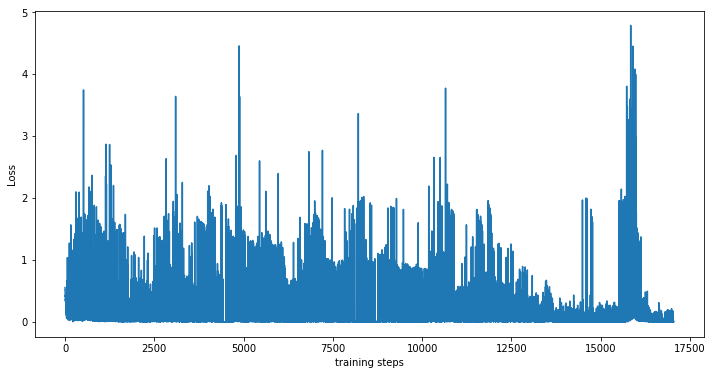

In [12]:
actor2.plot_loss()

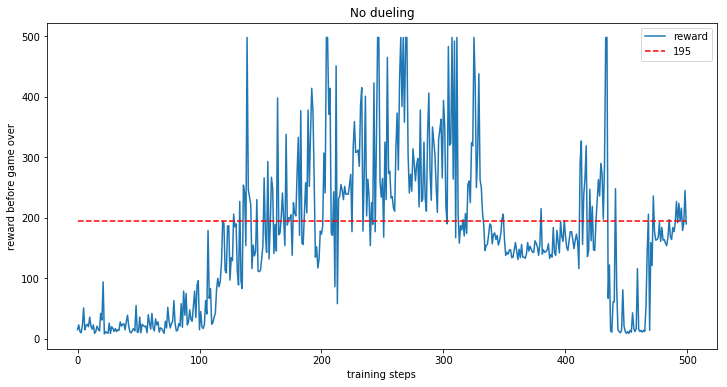

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(rewards2, label='reward')
plt.plot([195] * len(rewards2), c='r', linestyle='--', label='195')
plt.xlabel('training steps')
plt.ylabel('reward before game over')
plt.title('No dueling')
plt.legend();